In [202]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import scipy.stats as stats

## Data Cleaning and Preparation

In [164]:
os.chdir('C:/Users/Jason/Documents/Data Science/Fall 2019/Baysian Machine Learning/Project')

In [185]:
ed_data = pd.read_csv('ed_data.csv')
ed_data = ed_data.iloc[:,1:9] #removing the first index row

In [186]:
#preparing the data for analysis
passed = ed_data.iloc[:,7] #creating a variable for the exam results
replace_map = {'Year': {2010:0, 2011:1, 2012:2, 2013:3, 2014:4, 2015:5, 2016:6, 2017:7, 2018:8, 2019:9}}
ed_data = ed_data.replace(replace_map) #turning the years into categorical variables
replace_map1 = {'School': {'Albemarle':1, 'Charlottesville':2, 'Monticello':3, 'Western':4}} #mapping the schools into categories
ed_data = ed_data.replace(replace_map1) #turning the school into a categorical variable
year = ed_data['Year'] #creating a variable to store the year
school = ed_data['School'] #creating a variable to store the school
cols_to_drop = ['Year', 'Passed', 'School'] #dropping year, school and exam results from the main dataset since they are being stored separately
ed_data = ed_data.drop(cols_to_drop, axis=1)
ed_data.head()

,Race,Gender,Disadvantaged,ESOL,Disabled
0,Black,Female,0,0,0
1,Black,Female,0,0,0
2,Black,Female,0,0,0
3,Black,Female,0,0,0
4,Black,Female,0,0,0


In [187]:
#making the first two columns into dummies
test = []
for i in range(0,2): 
    test.append(pd.get_dummies(ed_data.iloc[:,i]))

dummies = test[0] 
for i in range(1,2): #combining all of the dummy variables into a single dataframe
    dummies = pd.concat([dummies, test[i]], axis=1)
dummies.head()

,Black,Hispanic,Other,White,Female,Male
0,1,0,0,0,1,0
1,1,0,0,0,1,0
2,1,0,0,0,1,0
3,1,0,0,0,1,0
4,1,0,0,0,1,0


In [188]:
#Removing the old columns that were not dummified, and then adding back in the new dummified columns
cols_to_drop = ['Race', 'Gender'] 
ed_data = ed_data.drop(cols_to_drop, axis=1) 

ed_data = pd.concat([ed_data, dummies], axis=1)
ed_data.head()

,Disadvantaged,ESOL,Disabled,Black,Hispanic,Other,White,Female,Male
0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0


In [189]:
#dropping one dummy for each of the categoricals so we can more easily compare relative results 
cols_to_drop = ['Female', 'White'] 
ed_data = ed_data.drop(cols_to_drop, axis=1) 
ed_data.head()

,Disadvantaged,ESOL,Disabled,Black,Hispanic,Other,Male
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


In [192]:
#setting a seed
SEED = np.random.seed(287)

## Pooled Model - No School

In [193]:
with Model() as full_model:
    Beta_j = pm.Normal('Betaj',mu=0, sd=1, shape=7)
    alpha = pm.Normal('alpha',0,sd=1, shape=1)
    theta = alpha + pm.math.dot(Beta_j, ed_data.T)
    p = 1 / (1+ np.exp(-theta))
    y = pm.Binomial('y', n=1, p=p, observed=passed)

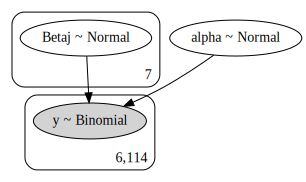

In [194]:
pm.model_to_graphviz(full_model)

In [195]:
with full_model:
    approx = pm.fit(10000, method = 'advi', random_seed = SEED)

Average Loss = 2,659.2: 100%|██████████████████████████████████████████████████| 10000/10000 [1:35:36<00:00,  1.62it/s]
Finished [100%]: Average Loss = 2,659.1


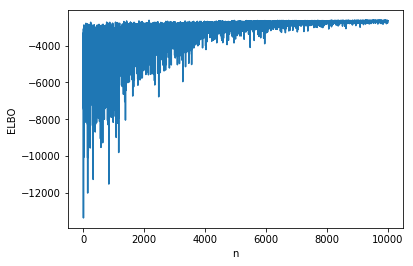

In [196]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [249]:
mu_3 = approx.mean.eval()
std_3 = approx.std.eval()

data = {"Names":["Disadvantaged", "ESOL", "Disabled","Black","Hispanic","Other","Female", "Intercept"],
"Mean": mu_3, "SD":std_3}
results_pooled = pd.DataFrame(data)
results_pooled
results_pooled.to_csv('pooled_results.csv')

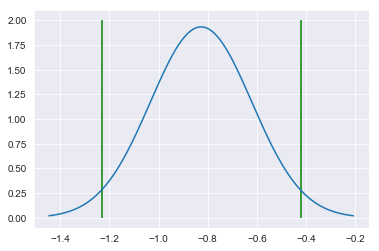

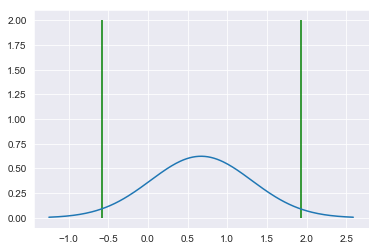

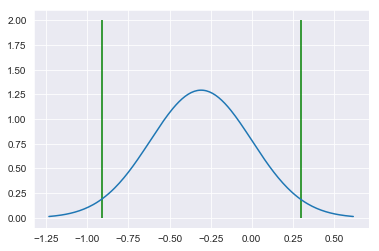

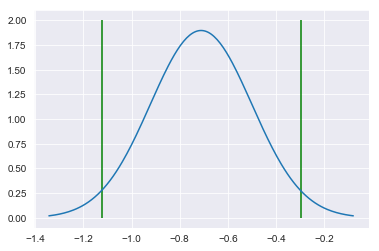

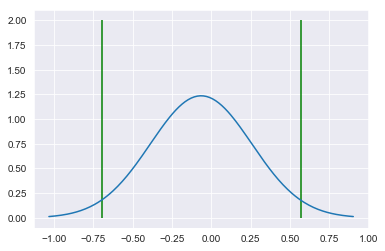

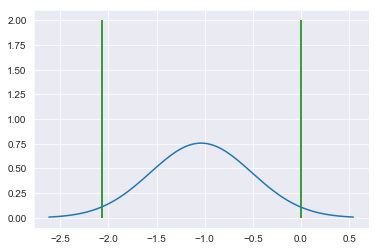

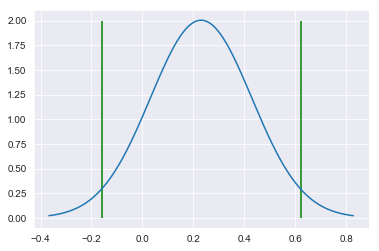

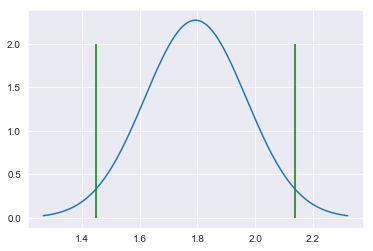

In [251]:
for i in range(0,8):
    sns.set_style("darkgrid")
    mu_test = mu_3[i]
    sd_test = std_3[i]
    x_data = np.linspace((mu_test-sd_test*3),(mu_test+sd_test*3),200)

    plt.plot(x_data,stats.norm.pdf(x_data, mu_test, sd_test))
    plt.vlines(x=(mu_test + sd_test * 1.96), ymin=0, ymax=2, color='green')
    plt.vlines(x=(mu_test - sd_test * 1.96), ymin=0, ymax=2, color='green')
    plt.show()


In [211]:
np.exp(-.43)

0.6505090947233165

## Unpooled Model

In [145]:
#preparing the data for the unpooled model 
#splitting off disability and disadvantaged
disadv = ed_data['Disadvantaged']
disabled = ed_data['Disabled']
cols_to_drop = ['Disabled', 'Disadvantaged'] 
ed_data2 = ed_data.drop(cols_to_drop, axis=1) 
ed_data2.head()

,Albemarle,Charlottesville,Monticello,Western,Black,Hispanic,Other,White,Female,Male
0,1,0,0,0,1,0,0,0,1,0
1,1,0,0,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1,0
3,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1,0


In [ ]:
schoolyear = []
for 

In [147]:
with Model() as unpooled_model:
    alpha = pm.Normal('alpha',0,sd=1, shape=40)
    Beta1 = pm.Normal('Beta1',mu=0, sd=1, shape=40)
    Beta2 = pm.Normal('Beta2',mu=0, sd=1, shape=40)
    Betaj = pm.Normal('Betaj',mu=0, sd=1, shape=5)
    theta = alpha[year] + Beta1[year]*disadv + Beta2[year]*disabled + Beta3[year]*ESOL + pm.math.dot(Betaj, ed_data2.T)
    p = 1 / (1+ np.exp(-theta))
    y = pm.Binomial('y', n=1, p=p, observed=passed)

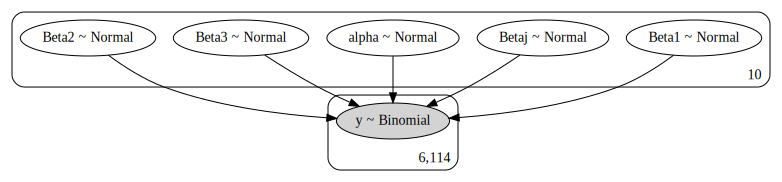

In [151]:
pm.model_to_graphviz(unpooled_model)

In [149]:
with unpooled_model:
    unpooled_approx = pm.fit(100, method = 'advi')

Average Loss = 5,404.2: 100%|████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]
Finished [100%]: Average Loss = 5,508.9


In [141]:
mu_4 = unpooled_approx.mean.eval()
std_4 = approx.std.eval()

In [144]:
unpooled_approx.mean.eval()

array([ 0.03077307,  0.02889703,  0.02070913,  0.02878184,  0.01941814,
        0.02540641,  0.0006255 , -0.00282084, -0.00254857, -0.0020863 ,
        0.0312756 ,  0.03125312,  0.02964912,  0.03005573,  0.03008153,
        0.02960707,  0.03165916,  0.02894311,  0.02882144,  0.02895938,
        0.00213091, -0.00052741, -0.00022178, -0.00167713, -0.00063213,
        0.00246938, -0.00122806,  0.02457464, -0.00488392,  0.00089477,
        0.0263571 ,  0.02357971,  0.00623517,  0.00774062,  0.02164175,
        0.01163721,  0.01683604,  0.00384095,  0.0034788 ,  0.01828315])

## Pooled Test

In [150]:
cols_to_drop = ['Western', 'White', 'Male'] 
ed_data_test = ed_data.drop(cols_to_drop, axis=1) 
ed_data_test.head()

,Disadvantaged,ESOL,Disabled,Albemarle,Charlottesville,Monticello,Black,Hispanic,Other,Female
0,0,0,0,1,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,1
2,0,0,0,1,0,0,1,0,0,1
3,0,0,0,1,0,0,1,0,0,1
4,0,0,0,1,0,0,1,0,0,1


In [155]:
with Model() as full_model_1:
    Beta_j = pm.Normal('Betaj',mu=0, sd=1, shape=10)
    alpha = pm.Normal('alpha',0,sd=1, shape=1)
    theta = alpha + pm.math.dot(Beta_j, ed_data_test.T)
    p = 1 / (1+ np.exp(-theta))
    y = pm.Binomial('y', n=1, p=p, observed=passed)

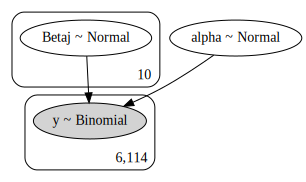

In [156]:
pm.model_to_graphviz(full_model_1)

In [157]:
with full_model_1:
    approx1 = pm.fit(15000, method = 'advi')

Average Loss = 2,631.7: 100%|██████████████████████████████████████████████████| 15000/15000 [2:19:15<00:00,  1.78it/s]
Finished [100%]: Average Loss = 2,631.7


In [158]:
mu_5 = approx1.mean.eval()


In [159]:
mu_5

array([-0.95529708,  0.58087836, -0.15436156, -0.0296844 ,  0.21307104,
       -0.12793158, -0.84896834, -0.06973478, -0.96578543,  0.11681364,
        1.89990384])

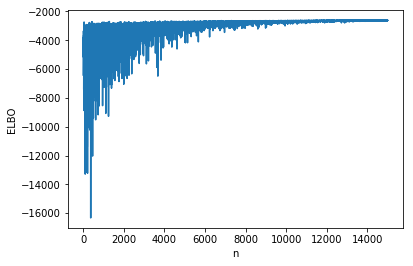

In [161]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx1.hist,
     'n': np.arange(approx1.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
